In [43]:
%pylab inline
import numpy as np
import scipy as sp
from matplotlib.pyplot import imread, quiver, quiverkey
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter, sobel, gaussian_filter1d
import cv2

Populating the interactive namespace from numpy and matplotlib


### images

In [152]:
notre_dame = imread('data/Notre Dame/1_o.jpg')
notre_dame2 = imread('data/Notre Dame/2_o.jpg')
features = loadmat('data/Notre Dame/f_o.mat')
notre_dame_f = np.hstack((features['x1'], features['y1']))
notre_dame2_f = np.hstack((features['x2'], features['y2']))

### Visualizators

In [162]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def plot_quiver(ax, hist, bins, scale=1, n=None):
    if n is None:
        n = len(hist)
    x, y = pol2cart(hist, bins)
    ax.quiver(np.zeros(n), np.zeros(n), x[:n], y[:n], units='xy', scale=scale)
    

### globals

In [35]:
PATCH_R = 20
PAD_SIZE = PATCH_R*2 + 1
BIN_N = 36
BIN_SIZE = 360/BIN_N
DOMINANT_ANGLE_PEAK_TRESHOLD = 0.9

### Image preprocesing functions

In [127]:
def rgb2y(img):
    return img.dot(np.array([ 0.2989,  0.5866,  0.1145]))

def normalize(img):
    return img / img.max()

def extract_rotate(pos, angle, scale, R):
    pos = np.array(pos)
    th = np.deg2rad(-angle)
    M = np.array([np.cos(th), -np.sin(th), np.sin(th), np.cos(th)]).reshape((2,2)) * scale
    def rotate(data):
        off = data - R
        off = np.einsum("ab,xb->xa", M, off)  # M[:, None, :].dot(off.T)[:, 0, :].T - broadcast dot product
        return pos + off
    return rotate
    

def img_transform(source_image, function, target_shape=None, constant=0, order=3, mode='constant'):
    if target_shape is None:
        target_shape = source_image.shape
    cx,cy = np.meshgrid(np.arange(target_shape[0]), np.arange(target_shape[1]))
    coords = np.stack((cx,cy), axis=2).reshape((-1,2), order='F')
    coords2 = np.fliplr(function(np.fliplr(coords)))
    assert coords.shape == coords2.shape, ("Original coords shape %s is not equal to modified coords shape %s." % (coords.shape, coords2.shape))
    pts = sp.ndimage.map_coordinates(source_image, coords2.T, order=order, mode=mode, cval=constant)
    pts = pts.T
    tshape = (target_shape[1], target_shape[0])
    pts = pts.reshape(tshape, order='F').transpose((1,0))
    return pts.copy()

def extract_patch(img, pos, angle=0, scale=1, R=PATCH_R):
    x, y = map(int, pos)
    if np.abs(angle) < 1 and scale==1:
        sl = (slice(y-R, y+R+1), slice(x-R, x+R+1))
        return img[sl]
    return img_transform(img, extract_rotate(pos, angle, scale, R), target_shape=(R*2 + 1, R*2 + 1))

### Kernel generators

In [37]:
def kernel_gen(sigma, R):
    def kernel(data):
        data = data - R
        dist = (data**2).sum(axis=1)
        return np.exp(-(dist)/(2 * (sigma**2)))
    return kernel

def img_gen(function, target_shape):
    cx, cy = np.meshgrid(np.arange(target_shape[0]), np.arange(target_shape[1]))
    coords = np.stack((cx,cy), axis=2).reshape((-1,2), order='F')
    pts = function(np.fliplr(coords))
    assert coords.shape[0] == pts.shape[0], ("Original coords shape %s is not mathching samples shape %s." % (coords.shape, pts.shape))
    tshape = (target_shape[1], target_shape[0], target_shape[2])
    pts = pts.reshape(tshape, order='F').transpose((1,0,2))
    return pts.copy()

def gaussian_kernel(sigma):
    return img_gen(kernel_gen(sigma, PATCH_R), (PATCH_R*2+1,PATCH_R*2+1,1))[:,:,0]

# Task 1 - Compute dominant orientation of features

In [38]:
def dominant_orientation(image, cgrad, gradangle, feature):    
    descrips = []
    x, y, scale = feature
    
    patch = extract_patch(image, [x,y])
    patch_cgrad = extract_patch(cgrad, [x,y])
    patch_gradangle = extract_patch(gradangle, [x,y])

    weights = gaussian_kernel(scale * 1.5) * np.abs(patch_cgrad)

    # Compute histogram
    _range = (-180 - BIN_SIZE/2, 180 + BIN_SIZE/2)
    hist, bins = np.histogram(a=patch_gradangle, bins=BIN_N + 1, range=_range, weights=weights, density=False)
    # sum the same ranges: 175:185, -185:-175
    hist[0] += hist[-1]
    hist = hist[0:BIN_N]
    hist_s = np.argsort(hist)
    bins += BIN_SIZE/2

    bins = bins[hist_s][::-1]
    hist = hist[hist_s][::-1]
    return hist, bins

def compute_features_dominant_orientation(image, features):
    # Convert image to intensity and normalize to [0, 1]
    I = normalize(rgb2y(image))

    # Add padding around I
    I = np.pad(I, ((PAD_SIZE,PAD_SIZE),(PAD_SIZE,PAD_SIZE)), mode='edge')
    features += np.array([PAD_SIZE, PAD_SIZE, 0])
    
    # Y is inverted, because the Y axis direction in complex space is different than in image space
    gradient_kernel = [-1.0, 0.0, 1.0]
    dY =  sp.ndimage.convolve1d(I, gradient_kernel, axis=0)
    dX = -sp.ndimage.convolve1d(I, gradient_kernel, axis=1)
    # magnitude
    cgrad = dX + 1j * dY
    # angle
    gradangle = np.angle(cgrad, deg=True)
    
    return [dominant_orientation(image=I, cgrad=cgrad, gradangle=gradangle, feature=f) for f in features]

In [155]:
r1 = compute_features_dominant_orientation(notre_dame, [(x, y, 1.5) for x, y in notre_dame_f])
r2 = compute_features_dominant_orientation(notre_dame2, [(x, y, 1.5) for x, y in notre_dame2_f])

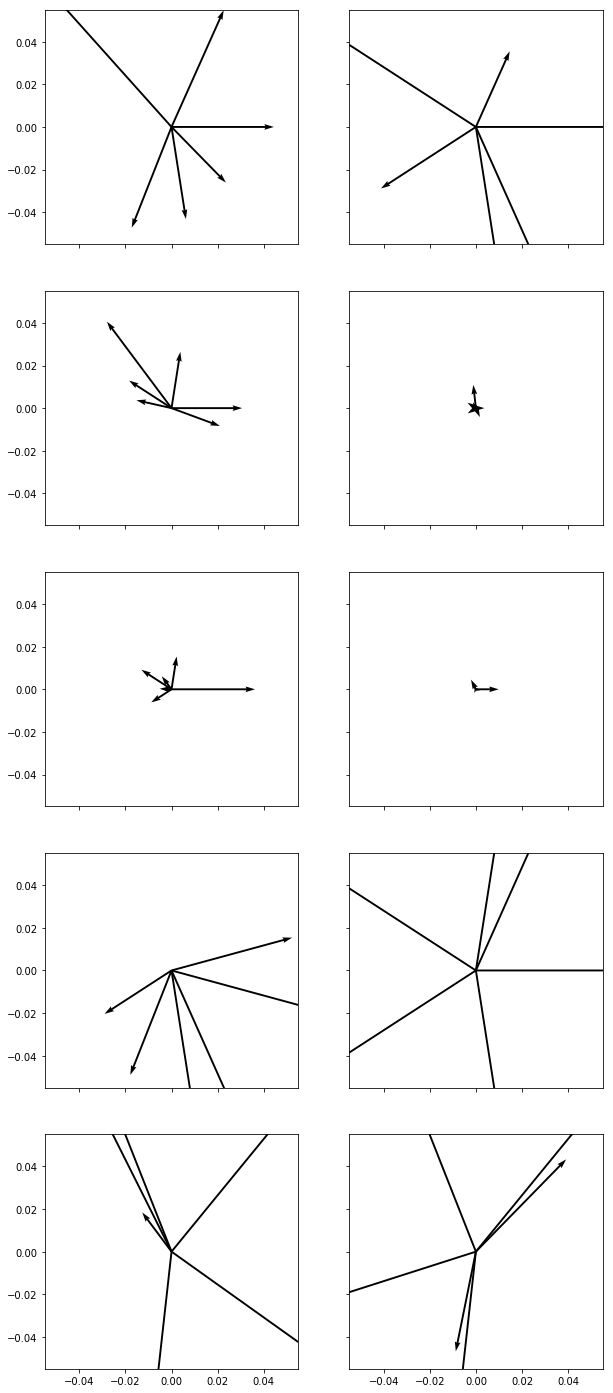

In [178]:
n = 5
fig = figure(figsize=(10, 25))
ax = fig.subplots(n, 2, sharex='col', sharey='row')
for i, ((h1, b1), (h2, b2))  in enumerate(zip(r1[:n], r2[:n])):
    plot_quiver(ax[i, 0], h1, b1, scale=10, n=6)
    plot_quiver(ax[i, 1], h2, b2, scale=10, n=6)
# plt.axis('equal')

# Task 2 - Feature descriptors

In [129]:
def feature_descriptor(image, feature, angle, kernel16):
    x, y, scale = feature
    rotated_patch = extract_patch(image, [x,y], angle, scale * 3 / 64, R=64)
    patch16 = cv2.resize(rotated_patch, (16,16), interpolation=cv2.INTER_AREA)
    
    gradient_kernel = [-1.0, 0.0, 1.0]
    dY16 =  sp.ndimage.convolve1d(patch16, gradient_kernel, axis=0)[:16,:16]
    dX16 = -sp.ndimage.convolve1d(patch16, gradient_kernel, axis=1)[:16,:16]
    cgrad16 = dX16 + 1j * dY16
    angle16 = np.angle(cgrad16, deg=True)

    # Smoothing weights
    cgrad16 = cgrad16 * kernel16
    magn16 = np.abs(cgrad16)

    d = []
    for Qy in [0,1,2,3]:
        for Qx in [0,1,2,3]:
            sy = slice(4*Qy, 4*Qy + 4)
            sx = slice(4*Qx, 4*Qx + 4)
            Qmagn16 = magn16[sy,sx]
            Qangle16 = angle16[sy,sx]
            Qhist, _ = np.histogram(Qangle16, 9, (-180 - 45, 180 + 45), weights=Qmagn16, density=False)
            Qhist[0] += Qhist[-1]
            Qhist = Qhist[:8]
            d += list(Qhist)

    assert(len(d) == 128)
    d = np.asarray(d).reshape(16,8)
    d = d/d.max();
    d[d > 0.2] = 0.2
    d = d/d.max();
    return x, y, scale, angle, d
    
def compute_features_descriptors(image, features):
    # Convert image to intensity and normalize to [0, 1]
    I = normalize(rgb2y(image))

    # Add padding around I
    I = np.pad(I, ((PAD_SIZE,PAD_SIZE),(PAD_SIZE,PAD_SIZE)), mode='edge')
    features += np.array([PAD_SIZE, PAD_SIZE, 0])
    
    # Y is inverted, because the Y axis direction in complex space is different than in image space
    gradient_kernel = [-1.0, 0.0, 1.0]
    dY =  sp.ndimage.convolve1d(I, gradient_kernel, axis=0)
    dX = -sp.ndimage.convolve1d(I, gradient_kernel, axis=1)
    # magnitude
    cgrad = dX + 1j * dY
    # angle
    gradangle = np.angle(cgrad, deg=True)
    
    # smoothing kernel
    kernel16 = img_gen(kernel_gen(4., 8), (16,16,1))[:,:,0]
    
    # compute histograms and bins
    histograms = [dominant_orientation(image=I, cgrad=cgrad, gradangle=gradangle, feature=f) for f in features]
    
    # compute dominant angles and descriptors
    descriptors = []
    for (hist, bins), f in zip(histograms, features):
        last_v = hist[0]
        dominant_angles = []
        for i, v in enumerate(hist):
            if v < DOMINANT_ANGLE_PEAK_TRESHOLD * last_v:
                break
            dominant_angles += [bins[i]]
            last_v = v
        descriptors += [feature_descriptor(image=I, feature=f, angle=a, kernel16=kernel16) for a in dominant_angles]
        
    d2 = []
    for x, y, scale, angle, descriptor in descriptors:
        l = np.asarray([x-PAD_SIZE, y-PAD_SIZE, scale, angle])
        d2 += [np.hstack([l,descriptor.ravel()])]
    d2 = np.asarray(d2)

    print(d2.shape)
    return d2

In [22]:
from lab4 import harris_corners, harris_corners_adaptive_non_maximal_supression

Populating the interactive namespace from numpy and matplotlib


In [150]:
img1 = normalize(rgb2y(notre_dame))
p1 = harris_corners_adaptive_non_maximal_supression(img1, n=100, sigma=1.5, treshold=0.3)

img2 = normalize(rgb2y(notre_dame2))
p2 = harris_corners_adaptive_non_maximal_supression(img2, n=100, sigma=1.5, treshold=0.3)

In [180]:
features1 = [(x, y, 1.5) for y, x in p1]
desc1 = compute_features_descriptors(notre_dame, [(x, y, 1.5) for x, y in notre_dame_f])

features2 = [(x, y, 1.5) for y, x in p2]
desc2 = compute_features_descriptors(notre_dame2, [(x, y, 1.5) for x, y in notre_dame2_f])

(203, 132)
(221, 132)


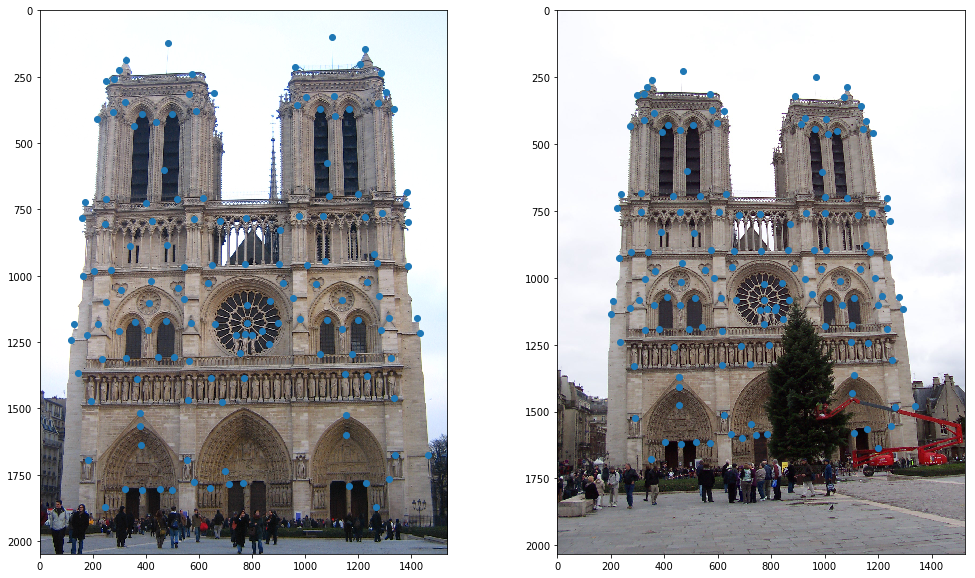

In [182]:
fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(notre_dame)
ax[0].scatter(notre_dame_f[:,0], notre_dame_f[:, 1])

ax[1].imshow(notre_dame2)
ax[1].scatter(notre_dame2_f[:,0], notre_dame2_f[:, 1])

In [188]:
from scipy.spatial.distance import cdist

C = desc2[np.argmin(cdist(desc1[:, 4:],desc2[:, 4:]),1)]

In [189]:
np.argmin(desc1[:, 4:]**2 + C[:, 4:]**2)

0

In [190]:
np.argmin(cdist(desc1[:, 4:],desc2[:, 4:]),1)[0]

85

In [191]:
x1, y1 = desc1[0][:2]
x2, y2 = desc2[85][:2]

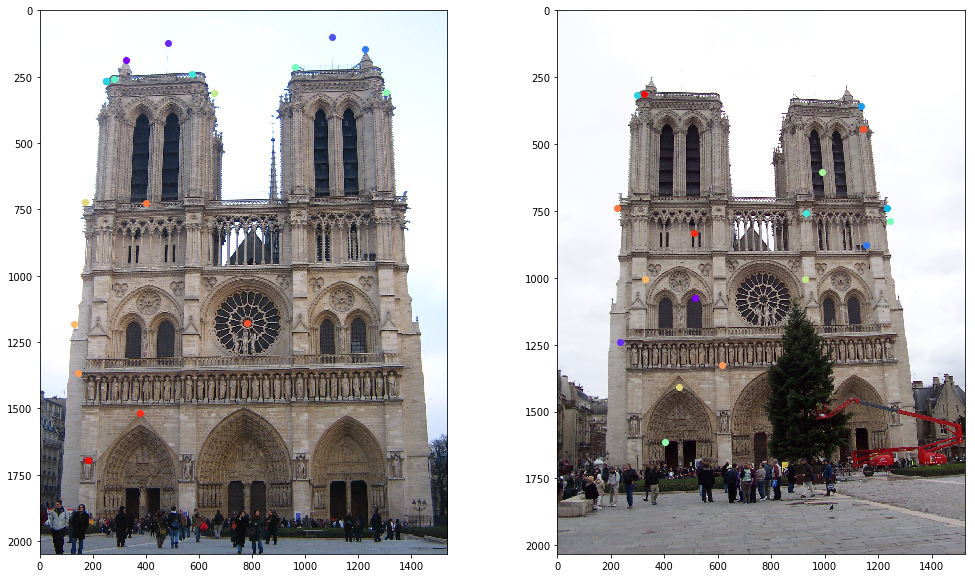

In [192]:
n = 20
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, n))

fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(notre_dame)
for (x, y), c in zip(desc1[:n, :2], colors):
    ax[0].scatter(x, y, color=c)

ax[1].imshow(notre_dame2)
for (x, y), c in zip(C[:n, :2], colors):
    ax[1].scatter(x, y, color=c)

In [138]:
from scipy.io import loadmat

In [139]:
x = loadmat('data/Notre Dame/f_o.mat')

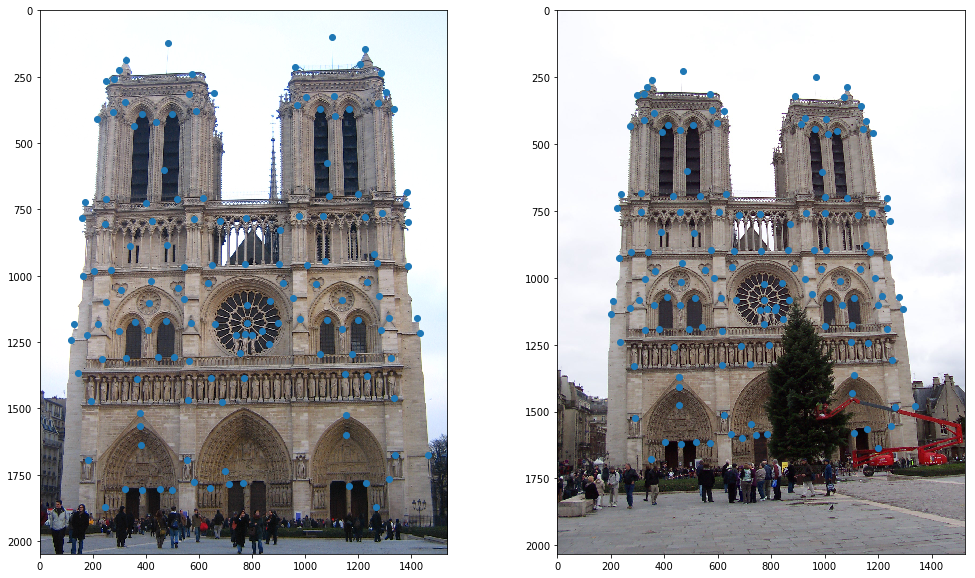

In [148]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, n))

fig = figure(figsize=(17, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(notre_dame)
ax[0].scatter(x['x1'], x['y1'])

ax[1].imshow(notre_dame2)
ax[1].scatter(x['x2'], x['y2'])